# Store Sales data

This is my first attempt at the Kaggle open competition for time series forecasting of store sales.

https://www.kaggle.com/competitions/store-sales-time-series-forecasting/data

## Things to consider

- Holidays, maybe people can't shop on them
- The earthquake caused massive rush on some types of items
- Maybe theres something we can do with store clustering
- Maybe theres something we can do about store location
- Days of the week might matter
- The paychecks on the 15th and end of the month effect sales

## Some helper functions to help calculate scores and plot data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_log_error, mean_absolute_error, r2_score, accuracy_score, precision_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import RandomizedSearchCV

def rmsle_score(y_test, y_preds):
    """
    Caculates root mean squared log error between predictions and
    true labels.
    """
    return np.sqrt(mean_squared_log_error(y_test, y_preds))

def calc_scores(y_test, y_pred):
    """
    Calculate the scores and print them
    """
    # Evaluate the model
    rmsle = rmsle_score(y_test, y_pred)
    print(f"Root Mean Square Log Error {rmsle}")
    
    mae = mean_absolute_error(y_test, y_pred)
    print(f"MAE: {mae}")
    
    r2 = r2_score(y_test,y_pred)
    print(f"R2: {r2}\n")

    return {
        "rmsle": rmsle,
        "mae": mae,
        "r2": r2
    }

def plot_features(columns, importances, n=20):
    df = (pd.DataFrame({"features": columns,
                        "feature_importances": importances})
          .sort_values("feature_importances", ascending=False)
          .reset_index(drop=True))
    
    # Plot the dataframe
    fig, ax = plt.subplots()
    ax.barh(df["features"][:n], df["feature_importances"][:20])
    ax.set_ylabel("Features")
    ax.set_xlabel("Feature importance")
    ax.invert_yaxis()

def is_pay_day(date):
    return date.day == 16 or date.day == 1


## Read in the store data

In [2]:
stores_df = pd.read_csv('stores.csv')
stores_df = stores_df.add_prefix('stores_')
stores_df.rename(columns={'stores_store_nbr': 'store_nbr'}, inplace=True)

stores_df.head()

,store_nbr,stores_city,stores_state,stores_type,stores_cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


## Read in the Sales data

In [3]:
store_sales_data = pd.read_csv('train.csv', parse_dates=['date'])
store_sales_data = store_sales_data.add_prefix('sales_')
store_sales_data.rename(columns={'sales_date': 'date', 'sales_store_nbr': 'store_nbr' }, inplace=True)
store_sales_data = store_sales_data.sort_values(by='date')

store_sales_data = store_sales_data.drop('sales_id', axis=1)

store_sales_data.set_index('date', inplace=True)

#unique_families = store_sales_data['sales_family'].unique()

store_sales_data.head()


,store_nbr,sales_family,sales_sales,sales_onpromotion
date,,,,
2013-01-01,1,AUTOMOTIVE,0.0,0
2013-01-01,42,CELEBRATION,0.0,0
2013-01-01,42,BREAD/BAKERY,0.0,0
2013-01-01,42,BOOKS,0.0,0
2013-01-01,42,BEVERAGES,0.0,0


## Calculate the previous months sales average for a family of products

In [5]:
previous_month_avg = store_sales_data.groupby('sales_family').resample('M')['sales_sales'].mean()

previous_month_avg = previous_month_avg.reset_index()

previous_month_avg.rename(columns={'sales_sales': 'prev_month_family_sales_avg'}, inplace=True)

# Merge with the original DataFrame
store_sales_data = store_sales_data.reset_index().merge(previous_month_avg, on=['date', 'sales_family'], how='left')

store_sales_data.head()

,date,store_nbr,sales_family,sales_sales,sales_onpromotion,prev_month_family_sales_avg
0,2013-01-01,1,AUTOMOTIVE,0.0,0,NaN
1,2013-01-01,42,CELEBRATION,0.0,0,NaN
2,2013-01-01,42,BREAD/BAKERY,0.0,0,NaN
3,2013-01-01,42,BOOKS,0.0,0,NaN
4,2013-01-01,42,BEVERAGES,0.0,0,NaN


In [6]:
# Backward fill - fills remaining NaNs with the previous valid entry
store_sales_data['prev_month_family_sales_avg'] = store_sales_data['prev_month_family_sales_avg'].bfill()

# Forward fill - fills NaNs with the next valid entry
store_sales_data['prev_month_family_sales_avg'] = store_sales_data['prev_month_family_sales_avg'].ffill()

store_sales_data.head()

,date,store_nbr,sales_family,sales_sales,sales_onpromotion,prev_month_family_sales_avg
0,2013-01-01,1,AUTOMOTIVE,0.0,0,0.0
1,2013-01-01,42,CELEBRATION,0.0,0,0.0
2,2013-01-01,42,BREAD/BAKERY,0.0,0,0.0
3,2013-01-01,42,BOOKS,0.0,0,0.0
4,2013-01-01,42,BEVERAGES,0.0,0,0.0


## Merge the Sales data with the Store data which has clusted, store type, and such

In [7]:
full_sales_df = pd.merge(store_sales_data, stores_df, on='store_nbr', how='left').copy()

full_sales_df.isna().sum()

date                           0
store_nbr                      0
sales_family                   0
sales_sales                    0
sales_onpromotion              0
prev_month_family_sales_avg    0
stores_city                    0
stores_state                   0
stores_type                    0
stores_cluster                 0
dtype: int64

## Include the Holiday data

In [8]:
holidays_df = pd.read_csv('holidays_events.csv', parse_dates=['date'])
holidays_df = holidays_df.add_prefix('holidays_')
holidays_df.rename(columns={'holidays_date': 'date'}, inplace=True)

len(holidays_df)

350

In [9]:
holiday_full_sales_df = pd.merge(full_sales_df, holidays_df, on='date', how='left').copy()

holiday_full_sales_df.head()

,date,store_nbr,sales_family,sales_sales,sales_onpromotion,prev_month_family_sales_avg,stores_city,stores_state,stores_type,stores_cluster,holidays_type,holidays_locale,holidays_locale_name,holidays_description,holidays_transferred
0,2013-01-01,1,AUTOMOTIVE,0.0,0,0.0,Quito,Pichincha,D,13,Holiday,National,Ecuador,Primer dia del ano,False
1,2013-01-01,42,CELEBRATION,0.0,0,0.0,Cuenca,Azuay,D,2,Holiday,National,Ecuador,Primer dia del ano,False
2,2013-01-01,42,BREAD/BAKERY,0.0,0,0.0,Cuenca,Azuay,D,2,Holiday,National,Ecuador,Primer dia del ano,False
3,2013-01-01,42,BOOKS,0.0,0,0.0,Cuenca,Azuay,D,2,Holiday,National,Ecuador,Primer dia del ano,False
4,2013-01-01,42,BEVERAGES,0.0,0,0.0,Cuenca,Azuay,D,2,Holiday,National,Ecuador,Primer dia del ano,False


# Calculate the previous months family sales

In [10]:
data = holiday_full_sales_df.copy()

# Set 'date' as the index
data.set_index('date', inplace=True)

# Group by store_cluster, sales_family, and month; then calculate mean sales
monthly_avg_sales = data.groupby(['stores_cluster', 'sales_family', pd.Grouper(freq='M')])['sales_sales'].mean()

monthly_avg_sales.name = 'prev_month_cluster_family_sales_avg'

# Display the result
print(monthly_avg_sales)

stores_cluster  sales_family  date      
1               AUTOMOTIVE    2013-01-31     2.344086
                              2013-02-28     3.119048
                              2013-03-31     2.655914
                              2013-04-30     2.788889
                              2013-05-31     2.760417
                                              ...    
17              SEAFOOD       2017-04-30    50.752322
                              2017-05-31    55.214000
                              2017-06-30    48.943469
                              2017-07-31    50.372469
                              2017-08-31    51.153067
Name: prev_month_cluster_family_sales_avg, Length: 31416, dtype: float64


## Merge the Holiday data with the Sales & Store data

In [11]:
holiday_full_sales_df = pd.merge(holiday_full_sales_df, monthly_avg_sales, on=['date','stores_cluster', 'sales_family'], how='left')

holiday_full_sales_df['prev_month_cluster_family_sales_avg'] = holiday_full_sales_df['prev_month_cluster_family_sales_avg'].bfill()
holiday_full_sales_df['prev_month_cluster_family_sales_avg'] = holiday_full_sales_df['prev_month_cluster_family_sales_avg'].ffill()

holiday_full_sales_df.head()

,date,store_nbr,sales_family,sales_sales,sales_onpromotion,prev_month_family_sales_avg,stores_city,stores_state,stores_type,stores_cluster,holidays_type,holidays_locale,holidays_locale_name,holidays_description,holidays_transferred,prev_month_cluster_family_sales_avg
0,2013-01-01,1,AUTOMOTIVE,0.0,0,0.0,Quito,Pichincha,D,13,Holiday,National,Ecuador,Primer dia del ano,False,0.0
1,2013-01-01,42,CELEBRATION,0.0,0,0.0,Cuenca,Azuay,D,2,Holiday,National,Ecuador,Primer dia del ano,False,0.0
2,2013-01-01,42,BREAD/BAKERY,0.0,0,0.0,Cuenca,Azuay,D,2,Holiday,National,Ecuador,Primer dia del ano,False,0.0
3,2013-01-01,42,BOOKS,0.0,0,0.0,Cuenca,Azuay,D,2,Holiday,National,Ecuador,Primer dia del ano,False,0.0
4,2013-01-01,42,BEVERAGES,0.0,0,0.0,Cuenca,Azuay,D,2,Holiday,National,Ecuador,Primer dia del ano,False,0.0


## Check that every column has a value

In [12]:
holiday_columns = ['holidays_type', 'holidays_locale', 'holidays_locale_name', 'holidays_description']

for column in holiday_columns:
    holiday_full_sales_df[column] = holiday_full_sales_df[column].fillna('NotAHoliday')

holiday_full_sales_df['holidays_transferred'] = holiday_full_sales_df['holidays_transferred'].fillna(False)

holiday_full_sales_df.isna().sum()

date                                   0
store_nbr                              0
sales_family                           0
sales_sales                            0
sales_onpromotion                      0
prev_month_family_sales_avg            0
stores_city                            0
stores_state                           0
stores_type                            0
stores_cluster                         0
holidays_type                          0
holidays_locale                        0
holidays_locale_name                   0
holidays_description                   0
holidays_transferred                   0
prev_month_cluster_family_sales_avg    0
dtype: int64

In [13]:
holiday_full_sales_df.head()

,date,store_nbr,sales_family,sales_sales,sales_onpromotion,prev_month_family_sales_avg,stores_city,stores_state,stores_type,stores_cluster,holidays_type,holidays_locale,holidays_locale_name,holidays_description,holidays_transferred,prev_month_cluster_family_sales_avg
0,2013-01-01,1,AUTOMOTIVE,0.0,0,0.0,Quito,Pichincha,D,13,Holiday,National,Ecuador,Primer dia del ano,False,0.0
1,2013-01-01,42,CELEBRATION,0.0,0,0.0,Cuenca,Azuay,D,2,Holiday,National,Ecuador,Primer dia del ano,False,0.0
2,2013-01-01,42,BREAD/BAKERY,0.0,0,0.0,Cuenca,Azuay,D,2,Holiday,National,Ecuador,Primer dia del ano,False,0.0
3,2013-01-01,42,BOOKS,0.0,0,0.0,Cuenca,Azuay,D,2,Holiday,National,Ecuador,Primer dia del ano,False,0.0
4,2013-01-01,42,BEVERAGES,0.0,0,0.0,Cuenca,Azuay,D,2,Holiday,National,Ecuador,Primer dia del ano,False,0.0


## Encode the categorical data columns

In [14]:
label_encoder = LabelEncoder()
categorical_columns = ['sales_family', 'store_nbr', 'stores_city', 'stores_state', 
                       'stores_type', 'stores_cluster', 'holidays_type', 'holidays_locale']
cat_columns = categorical_columns
for category_name in categorical_columns:
    holiday_full_sales_df[category_name] = label_encoder.fit_transform(holiday_full_sales_df[category_name])

holiday_full_sales_df.head()

,date,store_nbr,sales_family,sales_sales,sales_onpromotion,prev_month_family_sales_avg,stores_city,stores_state,stores_type,stores_cluster,holidays_type,holidays_locale,holidays_locale_name,holidays_description,holidays_transferred,prev_month_cluster_family_sales_avg
0,2013-01-01,0,0,0.0,0,0.0,18,12,3,12,3,1,Ecuador,Primer dia del ano,False,0.0
1,2013-01-01,41,6,0.0,0,0.0,3,0,3,1,3,1,Ecuador,Primer dia del ano,False,0.0
2,2013-01-01,41,5,0.0,0,0.0,3,0,3,1,3,1,Ecuador,Primer dia del ano,False,0.0
3,2013-01-01,41,4,0.0,0,0.0,3,0,3,1,3,1,Ecuador,Primer dia del ano,False,0.0
4,2013-01-01,41,3,0.0,0,0.0,3,0,3,1,3,1,Ecuador,Primer dia del ano,False,0.0


In [15]:
# These columns have descriptive names of what the holidays are that we don't need for right now
drop_columns = ['holidays_locale_name', 'holidays_description']

holiday_full_sales_df = holiday_full_sales_df.drop(drop_columns, axis=1)

holiday_full_sales_df.head()

,date,store_nbr,sales_family,sales_sales,sales_onpromotion,prev_month_family_sales_avg,stores_city,stores_state,stores_type,stores_cluster,holidays_type,holidays_locale,holidays_transferred,prev_month_cluster_family_sales_avg
0,2013-01-01,0,0,0.0,0,0.0,18,12,3,12,3,1,False,0.0
1,2013-01-01,41,6,0.0,0,0.0,3,0,3,1,3,1,False,0.0
2,2013-01-01,41,5,0.0,0,0.0,3,0,3,1,3,1,False,0.0
3,2013-01-01,41,4,0.0,0,0.0,3,0,3,1,3,1,False,0.0
4,2013-01-01,41,3,0.0,0,0.0,3,0,3,1,3,1,False,0.0


In [16]:
holiday_full_sales_df.isna().sum()

date                                   0
store_nbr                              0
sales_family                           0
sales_sales                            0
sales_onpromotion                      0
prev_month_family_sales_avg            0
stores_city                            0
stores_state                           0
stores_type                            0
stores_cluster                         0
holidays_type                          0
holidays_locale                        0
holidays_transferred                   0
prev_month_cluster_family_sales_avg    0
dtype: int64

# We'll work with only the 2013 and 2014 data for now

To make this a bit easier to work with I'll just start with all the data from 2013 and 2014. In future notebooks I'll work with the full data set and eventually submit something to the Kaggle competition.

In [33]:
holiday_full_sales_df['date'] = pd.to_datetime(holiday_full_sales_df['date'])
holiday_full_sales_df.set_index('date', inplace=True)
holiday_full_sales_df_sorted = holiday_full_sales_df.sort_index()

selected_years_df = holiday_full_sales_df_sorted[
    (holiday_full_sales_df_sorted.index.year == 2013) | (holiday_full_sales_df_sorted.index.year == 2014)
]

X = selected_years_df.drop('sales_sales', axis=1)  # Features (everything except 'sales')
y = selected_years_df['sales_sales']               # Target variable

len(selected_years_df)

1316898

## Split the data into a Train and Test set

In [34]:
# Split it into X & Y train test split
X = selected_years_df.drop('sales_sales', axis=1)  # Features (everything except 'sales')
y = selected_years_df['sales_sales']               # Target variable

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Use a Random Forest Regressor with SearchCV from Scikit Learn

This will help us tune the hyperparameters to find a better fitting model for out data.

In [35]:
# Initialize the Random Forest Regressor
rf_grid = {
    "n_estimators": np.arange(5, 250, 5),
    "max_depth": [None, 3, 5, 10, 15, 20],
    "min_samples_split": np.arange(2, 20, 2),
    "min_samples_leaf": np.arange(1, 20, 2),
    "max_features": [1, 5, 10, 25, 50],
    "max_samples": [40000, 80000, 160000]
}

rs_model = RandomizedSearchCV(
    RandomForestRegressor(n_jobs=-1, random_state=42),
    param_distributions=rf_grid,
    n_iter=2,
    cv=5,
    verbose=True,
)

# Train the model
rs_model.fit(X_train, y_train)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


RandomizedSearchCV(cv=5,
                   estimator=RandomForestRegressor(n_jobs=-1, random_state=42),
                   n_iter=2,
                   param_distributions={'max_depth': [None, 3, 5, 10, 15, 20],
                                        'max_features': [1, 5, 10, 25, 50],
                                        'max_samples': [40000, 80000, 160000],
                                        'min_samples_leaf': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19]),
                                        'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18]),
                                        'n_estimators': array([  5,  10,  15,  20,  25,  30,  35,  40,  45,  50,  55,  60,  65,
        70,  75,  80,  85,  90,  95, 100, 105, 110, 115, 120, 125, 130,
       135, 140, 145, 150, 155, 160, 165, 170, 175, 180, 185, 190, 195,
       200, 205, 210, 215, 220, 225, 230, 235, 240, 245])},
                   verbose=True)

## Calculate the RMSLE (Root Mean Square Log Error) the measure by which this competion is scored

With a RMSLE of 0.86 I'd be somewhere around the top 500 on the leaderboard which is not a great score but for a first pass it isn't bad.

In [36]:
# Predict on the test set
y_valid = rs_model.best_estimator_.predict(X_train)
print(f"Training score")
calc_scores(y_valid, y_train);

print(f"Test Score")
y_pred = rs_model.best_estimator_.predict(X_test)
calc_scores(y_test,y_pred);

Training score
Root Mean Square Log Error 0.808619259206321
MAE: 75.17317327272647
R2: 0.8525754411315394

Test Score
Root Mean Square Log Error 0.8068196686135161
MAE: 74.5857780008393
R2: 0.8721043018088058



## Plot the most important features

Looking at the features from Most important to Least is:

1. The "sales_family" or the family of product that the is being sold is of course super important here. It's not really surprising as this whole process is kind of a function of the date + family = sales.

2. The store number, if it was on promotion, and the store type (not sure what that is exactly) were also very important. 

3. Things like which cluster the store is part of, the state, and city still hold some importance. Maybe there's something more to look into there to look into for the next pass.

Notes:
I still haven't taken a look at the full data set, included the data for sales that happened after the volcanoe, or cauclated and submitted values for the test set to Kaggle. I'm also still using the base libraries like pandas and scikit learn for this and there's probably libraries that could do this a bit better like XGBoost.

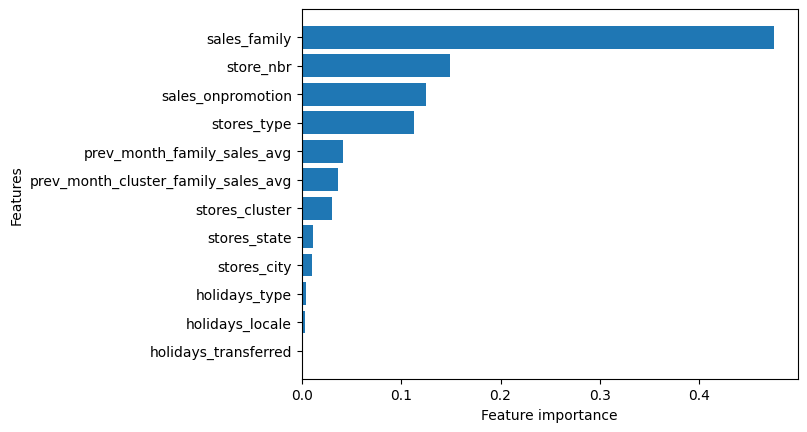

In [37]:
plot_features(X_train.columns, rs_model.best_estimator_.feature_importances_)